In [58]:
from torch_geometric.data import HeteroData
from torch_geometric.datasets import Entities
from torch_geometric.transforms.random_node_split import RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GraphConv, to_hetero
import torch.nn.functional as F
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
import numpy as np

Graf formiran u prethodnom koraku je usmeren. Međutim, usmerenje grana za ovaj skup podataka nije bitno, tako da se vrši transformacija u neusmereni graf. [`ToUndirected()`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.ToUndirected.html) svakoj postojećoj grani grafa dodaje granu suprotnog usmerenja (povratnu granu, označena prefiksom `rev_` kod naziva relacije). Pored ove transformacije, izvršava se i normalizacija podataka i podela na skupove za trening, validaciju i testiranje.

In [47]:
data = torch.load('data/hetero_data.pt')
data = T.ToUndirected()(data)
data = T.NormalizeFeatures()(data)
split = RandomNodeSplit(num_test=0.33, num_val=0.2)

data = split(data)

[`RandomNodeSplit()`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.RandomNodeSplit.html) dodaje `train_mask`, `val_mask` i `test_mask` vektore. Ovi vektori su dužine broja instanci i sadrže vrednost 1 ako instanca pripada trening/test/validacionom skupu, 0 u suprotnom.

In [48]:
data

HeteroData(
  incident={
    x=[141707, 51],
    y=[141707],
    train_mask=[141707],
    val_mask=[141707],
    test_mask=[141707],
  },
  support_org={ x=[141707, 17] },
  customer={ x=[141707, 16] },
  vendor={ x=[141707, 16] },
  (incident, assigned, support_org)={ edge_index=[2, 141707] },
  (incident, assigned, vendor)={ edge_index=[2, 141707] },
  (incident, reported, customer)={ edge_index=[2, 141707] },
  (support_org, rev_assigned, incident)={ edge_index=[2, 141707] },
  (vendor, rev_assigned, incident)={ edge_index=[2, 141707] },
  (customer, rev_reported, incident)={ edge_index=[2, 141707] }
)

## Grafovske konvolutivne mreže

**Problem:** U zadatom grafu $G = (V, E)$ čvorovi podskupa $V_L$ skupa čvorova su obeleženi, dok čvorovi podskupa $V_U$ nisu obeleženi $(V = (V_L \bigcup V_U))$. Potrebno je odrediti funkciju $f$ sa parametrima $\textbf{W}$ koja za čvor $u$, $\forall u\in V_L$, predviđa labelu $z_u$ čija je stvarna labela $y_u$ sa minimalnom greškom.

Grafovska konvolutivna mreža izračunava atribute čvora $u$, $\forall u \in V_L$ narednog sloja mreže na osnovu agregiranih informacija iz susedstva čvora $u$. Operator za računanje narednog sloja mreže korišćen ovde je [GraphSAGE](https://arxiv.org/pdf/1706.02216.pdf) (SAmple and aggreGatE). Pravilo propagacije za GraphSAGE je sledeće:
$$
h^{k}_{u} = \sigma(W \cdot MEAN(\{h^{k-1}_{u}\}\cup \{h^{k-1}_{v}, \forall v \in \textit{N}(u)\}))
$$
pri čemu skup $\textit{N}(u)$ sadrži sve susede čvora $u$, $\sigma$ je aktivaciona funkcija (npr. $ReLU$).

SAGEConv operator paketa PyG koji je zasnovan na GraphSAGE se ne može koristiti nad heterogenim grafovima. Čvorovi i grane su različitih tipova, pa se nad njima ne mogu koristiti iste funkcije. Funkcija [`to_hetero()`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero) transformiše homogeni model u heterogeni, tako da svaki tip čvora prosleđuje informacije ostalim tipovima čvorova. Rezultat primene `to_hetero()` se može videti na sledećoj slici:

![to_hetero](assets/to_hetero.png)

In [49]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels[0], aggr='mean')
        self.conv2 = SAGEConv((-1, -1), hidden_channels[1], aggr='mean')
        self.conv3 = SAGEConv((-1, -1), out_channels, aggr='mean')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.softmax(self.conv3(x, edge_index), dim=1)

        return x


gcn = GCN(hidden_channels=[256, 128], out_channels=2)
gcn = to_hetero(gcn, data.metadata(), aggr='sum')
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001, weight_decay=5e-4)

In [56]:
def train(model, data, optimizer, n_epochs=200):
    train_accs = []
    val_accs = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        mask = data['incident'].train_mask
        loss_fn = F.cross_entropy(out['incident'][mask], data['incident'].y[mask].type(torch.LongTensor))
        loss_fn.backward(retain_graph=True)
        optimizer.step()

        val_acc = evaluate(model, data, data['incident'].val_mask, test_flag=False)
        train_acc = (out['incident'][mask].argmax(dim=-1) == data['incident'].y[mask]).sum()/float(mask.sum())
        if epoch % 20 == 0:
            print(f'\tEpoch: {epoch}, train_acc: {train_acc:.5f}, val_acc: {val_acc:.5f}')

        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_accs, val_accs


def evaluate(model, data, mask, test_flag):
    with torch.no_grad():
        model.eval()
        out = model(data.x_dict, data.edge_index_dict)['incident']
        pred = out.argmax(dim=-1)
        correct = (pred[mask] == data['incident'].y[mask]).sum()

        acc_score = correct/float(mask.sum())
        
        if test_flag:
            return acc_score, metrics.confusion_matrix(y_pred=pred[mask], y_true=data['incident'].y[mask])

        return acc_score

In [51]:
EPOCHS = 200
train_accuracies, val_accuracies = train_losses, val_losses = train(gcn, data, optimizer, EPOCHS)

 10%|████████                                                                         | 20/200 [05:15<47:12, 15.73s/it]

	Epoch: 20, train_acc: 0.51711, val_acc: 0.52080


 20%|████████████████▏                                                                | 40/200 [10:29<41:38, 15.62s/it]

	Epoch: 40, train_acc: 0.53546, val_acc: 0.54179


 30%|████████████████████████▎                                                        | 60/200 [15:43<37:21, 16.01s/it]

	Epoch: 60, train_acc: 0.54328, val_acc: 0.55129


 40%|████████████████████████████████▍                                                | 80/200 [20:56<31:28, 15.73s/it]

	Epoch: 80, train_acc: 0.54514, val_acc: 0.55983


 50%|████████████████████████████████████████                                        | 100/200 [26:16<26:02, 15.63s/it]

	Epoch: 100, train_acc: 0.57227, val_acc: 0.57263


 60%|████████████████████████████████████████████████                                | 120/200 [31:43<22:32, 16.91s/it]

	Epoch: 120, train_acc: 0.58041, val_acc: 0.58110


 70%|████████████████████████████████████████████████████████                        | 140/200 [37:09<15:42, 15.71s/it]

	Epoch: 140, train_acc: 0.58946, val_acc: 0.58212


 80%|████████████████████████████████████████████████████████████████                | 160/200 [42:21<10:25, 15.63s/it]

	Epoch: 160, train_acc: 0.60766, val_acc: 0.60139


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [47:33<05:10, 15.50s/it]

	Epoch: 180, train_acc: 0.61804, val_acc: 0.61935


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [52:45<00:00, 15.83s/it]

	Epoch: 200, train_acc: 0.63740, val_acc: 0.63639


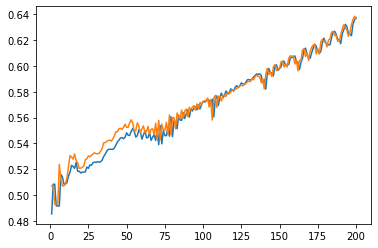

In [52]:
plt.plot(np.arange(1, EPOCHS+1), train_accuracies)
plt.plot(np.arange(1, EPOCHS+1), val_accuracies)

In [59]:
acc_score, confusion_matrix = evaluate(gcn, data, data['incident'].test_mask, test_flag=True)
print(f'Test accuracy score: {acc_score:.5f}')

Test accuracy score: 0.63411


In [65]:
confusion_matrix

array([[15819,  7343],
       [ 9767, 13834]], dtype=int64)

In [64]:
gcn

GraphModule(
  (conv1): ModuleDict(
    (incident__assigned__support_org): SAGEConv((-1, -1), 256, aggr=mean)
    (incident__assigned__vendor): SAGEConv((-1, -1), 256, aggr=mean)
    (incident__reported__customer): SAGEConv((-1, -1), 256, aggr=mean)
    (support_org__rev_assigned__incident): SAGEConv((-1, -1), 256, aggr=mean)
    (vendor__rev_assigned__incident): SAGEConv((-1, -1), 256, aggr=mean)
    (customer__rev_reported__incident): SAGEConv((-1, -1), 256, aggr=mean)
  )
  (conv2): ModuleDict(
    (incident__assigned__support_org): SAGEConv((-1, -1), 128, aggr=mean)
    (incident__assigned__vendor): SAGEConv((-1, -1), 128, aggr=mean)
    (incident__reported__customer): SAGEConv((-1, -1), 128, aggr=mean)
    (support_org__rev_assigned__incident): SAGEConv((-1, -1), 128, aggr=mean)
    (vendor__rev_assigned__incident): SAGEConv((-1, -1), 128, aggr=mean)
    (customer__rev_reported__incident): SAGEConv((-1, -1), 128, aggr=mean)
  )
  (conv3): ModuleDict(
    (incident__assigned__suppo

In [62]:
torch.save(gcn, 'data/model.pt')